# Emotion Dataset Overview

This notebook provides basic exploratory analysis of an emotion dataset and prepare it for Natural Language Processing (NLP) tasks.

---

## Table of Contents

1. [Imports](#imports)
2. [Examining class distribution)](#examining-class-distribution)
3. [Text length analysis)](#text-length-analysis)
4. [Analysis of the most frequently occurring words](#analysis-of-the-most-frequently-occurring-words)
5. [Saving to file](#saving-to-file)

# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk

# Examining class distribution

In [2]:
emotion_df = pd.read_parquet('emotion/emotion_dataset.parquet')

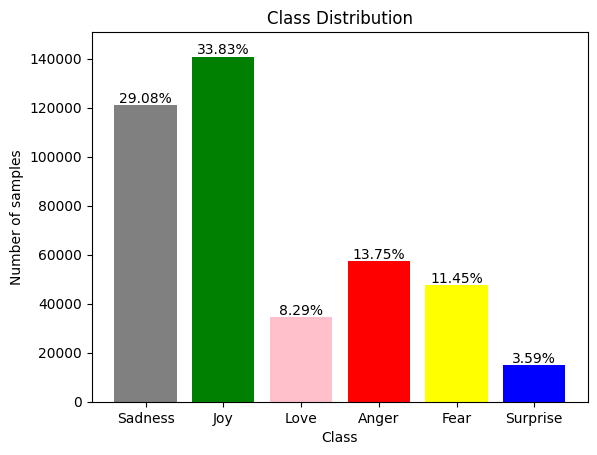

In [4]:
class_counts = emotion_df['label'].value_counts()
class_labels = {0: 'Sadness', 1: 'Joy', 2: 'Love', 3: 'Anger', 4: 'Fear', 5: 'Surprise'}
class_percentages = (class_counts / class_counts.sum()) * 100

class_counts_dict = {class_labels[key]: class_counts[key] for key in class_labels.keys()}
class_percentages_dict = {class_labels[key]: class_percentages[key] for key in class_labels.keys()}

plt.bar(class_counts_dict.keys(), class_counts_dict.values(), color=['grey', 'green', 'pink', 'red', 'yellow', 'blue'])

for label, count in class_counts_dict.items():
    percentage = f'{class_percentages_dict[label]:.2f}%'
    plt.text(list(class_counts_dict.keys()).index(label), count + 1000, percentage, ha='center')

plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of samples")
plt.ylim(0, class_counts.max() + 10000)
plt.show()

The dataset has an imbalanced distribution.

For training NLP models, this imbalance can lead to biased predictions favoring the majority class while underrepresenting the minority class. To address this issue, class weighting will be applied during model training.

# Text length analysis

In [5]:
emotion_df['text_length'] = emotion_df['text'].apply(len)

In [6]:
emotion_df['text_length'].describe()

count    416120.000000
mean         97.101182
std          56.175650
min           4.000000
25%          54.000000
50%          86.000000
75%         128.000000
max         830.000000
Name: text_length, dtype: float64

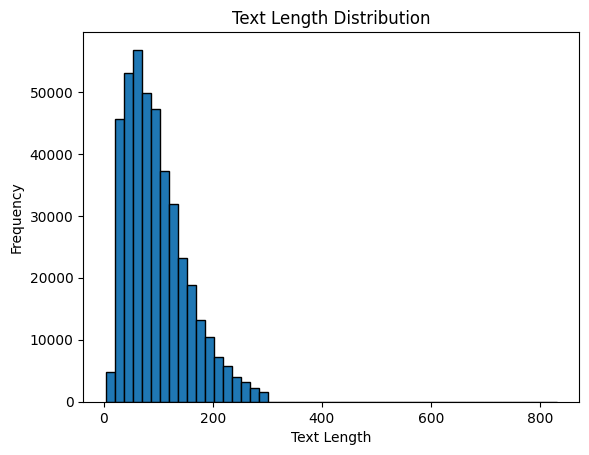

In [7]:
plt.hist(emotion_df['text_length'], bins=50, edgecolor='black')
plt.title("Text Length Distribution")
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.show()

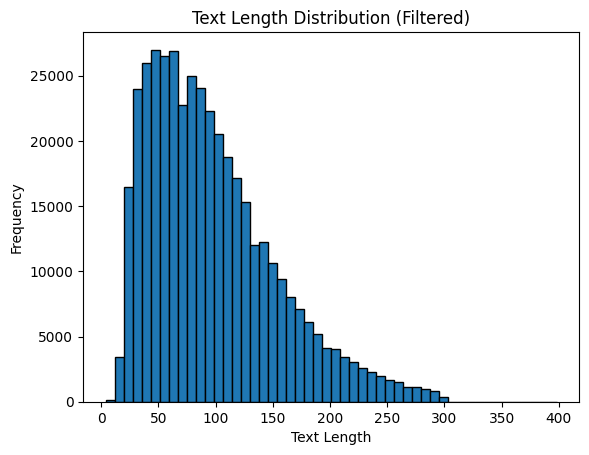

In [8]:
plt.hist(emotion_df[emotion_df['text_length'] < 400]['text_length'], bins=50, edgecolor='black')
plt.title("Text Length Distribution (Filtered)")
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.show()

Some texts are of considerable length (which may affect the setting of the maximum token length). There is a need to remove outliers.

Text length column - LB: -57.0   UB: 239.0


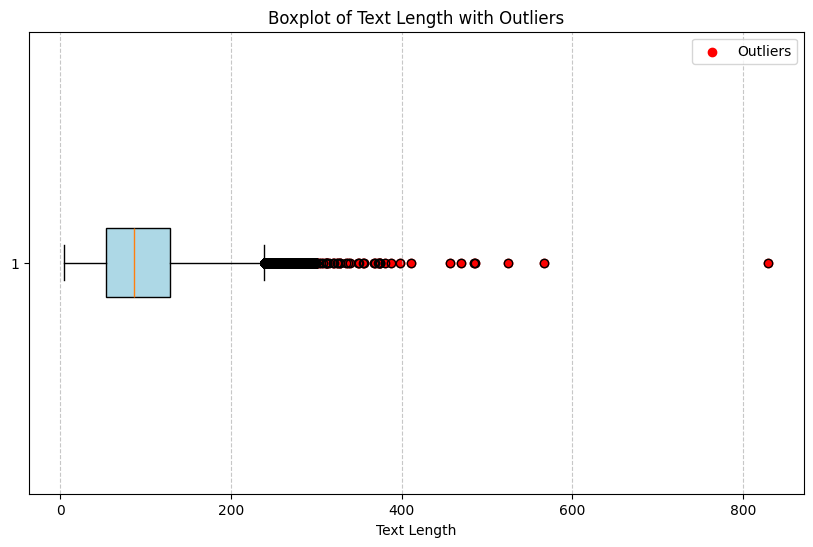

Outliers:
                                                     text  label  text_length
40      i feel doubtful about my place in the world of...      4          292
69      i actually think i am a fairly authentic perso...      0          265
101     i try not to be too dismissive of elections si...      1          243
218     i feel it s just really boring if you were to ...      0          275
289     i forgive myself for accepting and allowing my...      2          269
...                                                   ...    ...          ...
415934  i have created hundreds of beautiful memories ...      1          298
415947  im still feeling regretful that i was less pat...      0          264
415949  i mentioned facebook i think you said it wasnt...      0          253
415972  i just reviewed that writing and i suspect tha...      0          290
415978  i mean no harm i just want to express my inner...      3          246

[9951 rows x 3 columns]


In [9]:
q1 = emotion_df['text_length'].quantile(0.25)
q3 = emotion_df['text_length'].quantile(0.75)
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = emotion_df[(emotion_df['text_length'] < lower_bound) |
                      (emotion_df['text_length'] > upper_bound)]

print(f'Text length column - LB: {lower_bound}   UB: {upper_bound}')

plt.figure(figsize=(10, 6))
plt.boxplot(emotion_df['text_length'], vert=False, patch_artist=True, boxprops=dict(facecolor="lightblue"))
plt.scatter(outliers['text_length'], [1] * len(outliers), color='red', label='Outliers')

plt.title('Boxplot of Text Length with Outliers')
plt.xlabel('Text Length')
plt.legend()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

print(f"Outliers:\n{outliers}")

### In the context of training NLP models, I've decided to remove outliers where the text length exceeds the 256 token length.

In [10]:
emotion_df = emotion_df[emotion_df['text_length'] <= 256]

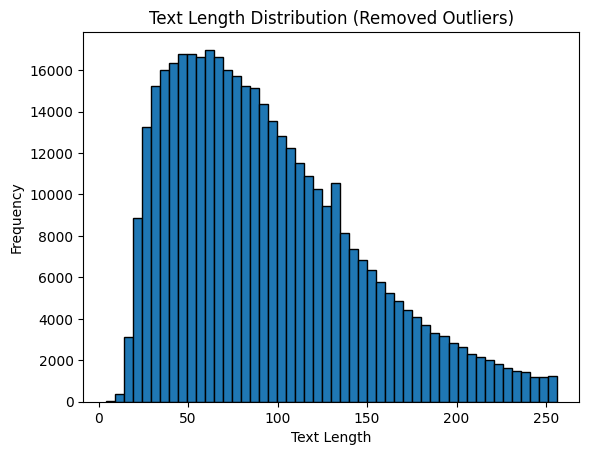

In [11]:
plt.hist(emotion_df['text_length'], bins=50, edgecolor='black')
plt.title("Text Length Distribution (Removed Outliers)")
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.show()

Text length column - LB: -56.5   UB: 235.5


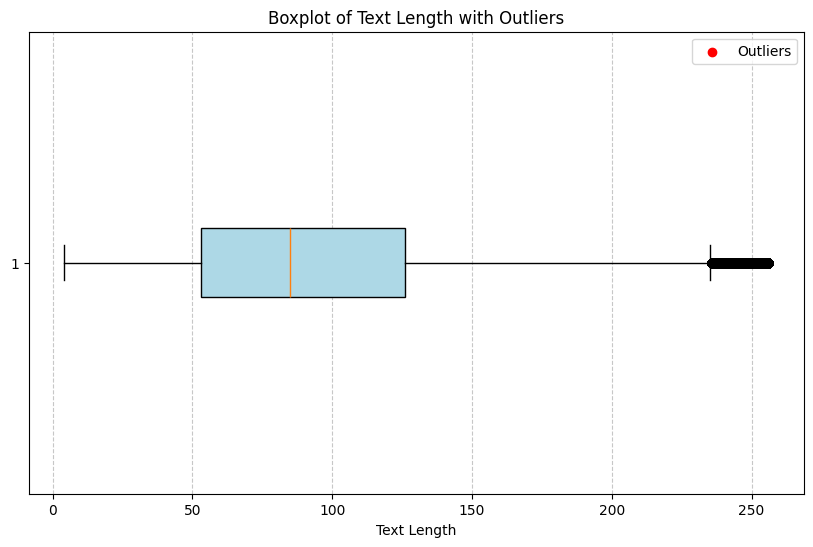

Outliers:
                                                     text  label  text_length
101     i try not to be too dismissive of elections si...      1          243
303     i was stood with slade frontman noddy holder a...      1          240
307     i called his sister as kak lng as he call and ...      1          236
418     i am not sure what i feel about the ludicrous ...      0          246
433     i feel intimidated by the whole thing right no...      4          238
...                                                   ...    ...          ...
415750  i don t though i might have in the past have t...      3          240
415807  i got through that one and realized that these...      4          244
415949  i mentioned facebook i think you said it wasnt...      0          253
415978  i mean no harm i just want to express my inner...      3          246
416062  i think i dont like really telling people how ...      1          239

[5029 rows x 3 columns]


In [12]:
q1 = emotion_df['text_length'].quantile(0.25)
q3 = emotion_df['text_length'].quantile(0.75)
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = emotion_df[(emotion_df['text_length'] < lower_bound) |
                      (emotion_df['text_length'] > upper_bound)]

print(f'Text length column - LB: {lower_bound}   UB: {upper_bound}')

plt.figure(figsize=(10, 6))
plt.boxplot(emotion_df['text_length'], vert=False, patch_artist=True, boxprops=dict(facecolor="lightblue"))
plt.scatter(outliers['text_length'], [1] * len(outliers), color='red', label='Outliers')

plt.title('Boxplot of Text Length with Outliers')
plt.xlabel('Text Length')
plt.legend()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

print(f"Outliers:\n{outliers}")

# Analysis of the most frequently occurring words

In [13]:
all_words = ' '.join(emotion_df['text']).split()
word_freq = Counter(all_words)

In [14]:
print("Ten most common words:", word_freq.most_common(10))

Ten most common words: [('i', 657448), ('feel', 284862), ('and', 238662), ('to', 222564), ('the', 205332), ('a', 156203), ('feeling', 131793), ('that', 124639), ('of', 123394), ('my', 106531)]


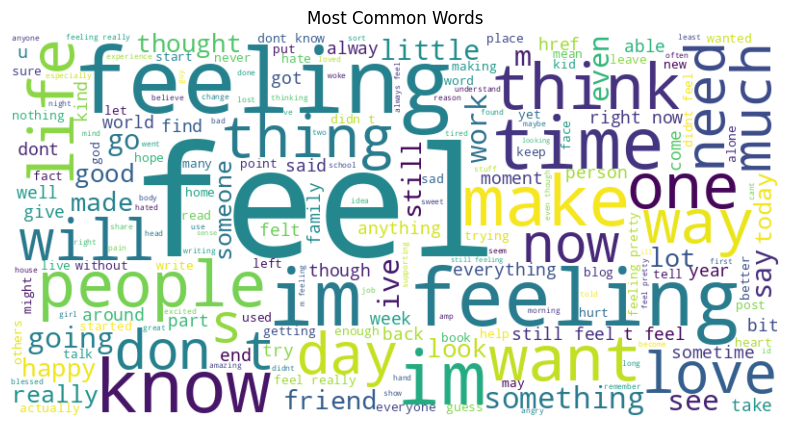

In [15]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(all_words))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Common Words")
plt.show()

The WordCloud visualization highlights the most frequently occurring words in the dataset. Common words such as "feel," "feeling," "think," and "know" dominate the text. The prominence of words like "feel" and "feeling" reflects the emotional nature of the dataset, suggesting that the text often describes or conveys personal emotions and states of mind. While some generic words (e.g., "and," "to," "the") are present, their inclusion aligns with the context of emotion analysis, where they may contribute to the overall sentence structure and meaning. These words will not be removed from the dataset as they can still influence the training and understanding of the model when predicting emotions.

In [16]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Adam\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
all_words = ' '.join(emotion_df['text']).split()
filtered_words = [word for word in all_words if word.lower() not in stop_words]

word_freq = Counter(filtered_words)

In [18]:
print("Ten most common words (excluding stop words):", word_freq.most_common(10))

Ten most common words (excluding stop words): [('feel', 284862), ('feeling', 131793), ('like', 71764), ('im', 60168), ('really', 25090), ('know', 22794), ('time', 20388), ('get', 18725), ('little', 18672), ('people', 17254)]


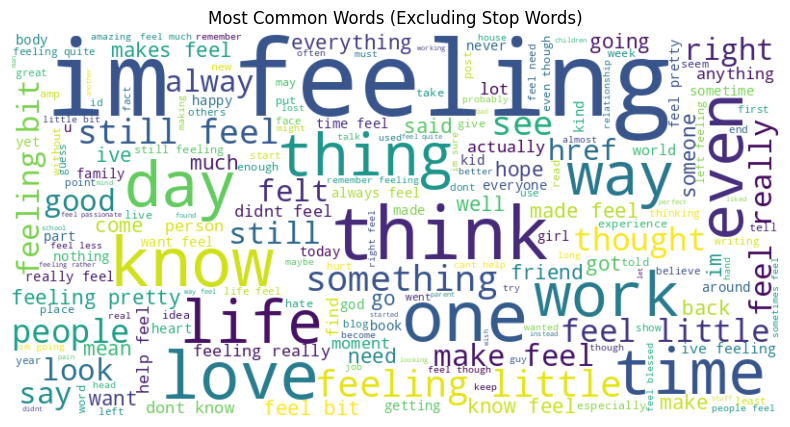

In [19]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(filtered_words))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Common Words (Excluding Stop Words)")
plt.show()

The data was previously cleaned at an earlier stage.

# Saving to file

In [20]:
emotion_df.to_csv(
    'emotion_without_outliers/emotion_without_outliers.csv',
    index=False,
    sep=',',
    encoding='utf-8'
)

emotion_df.to_parquet(
    'emotion_without_outliers/emotion_without_outliers.parquet',
    index=False,
)